/var/folders/8_/lltwgz4x48ncx3q3k86fr_tm0000gq/T/ipykernel_2714/610367347.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_locati

Loaded model weights with strict=True
0.024953842163085938
Prediction shape for prof_22303.json: torch.Size([1, 50, 2])
0.02961111068725586
Prediction shape for prof_3109.json: torch.Size([1, 50, 2])
0.025672197341918945
Prediction shape for prof_1134.json: torch.Size([1, 50, 2])
0.027981042861938477
Prediction shape for prof_10788.json: torch.Size([1, 50, 2])
0.03821992874145508
Prediction shape for prof_15070.json: torch.Size([1, 50, 2])


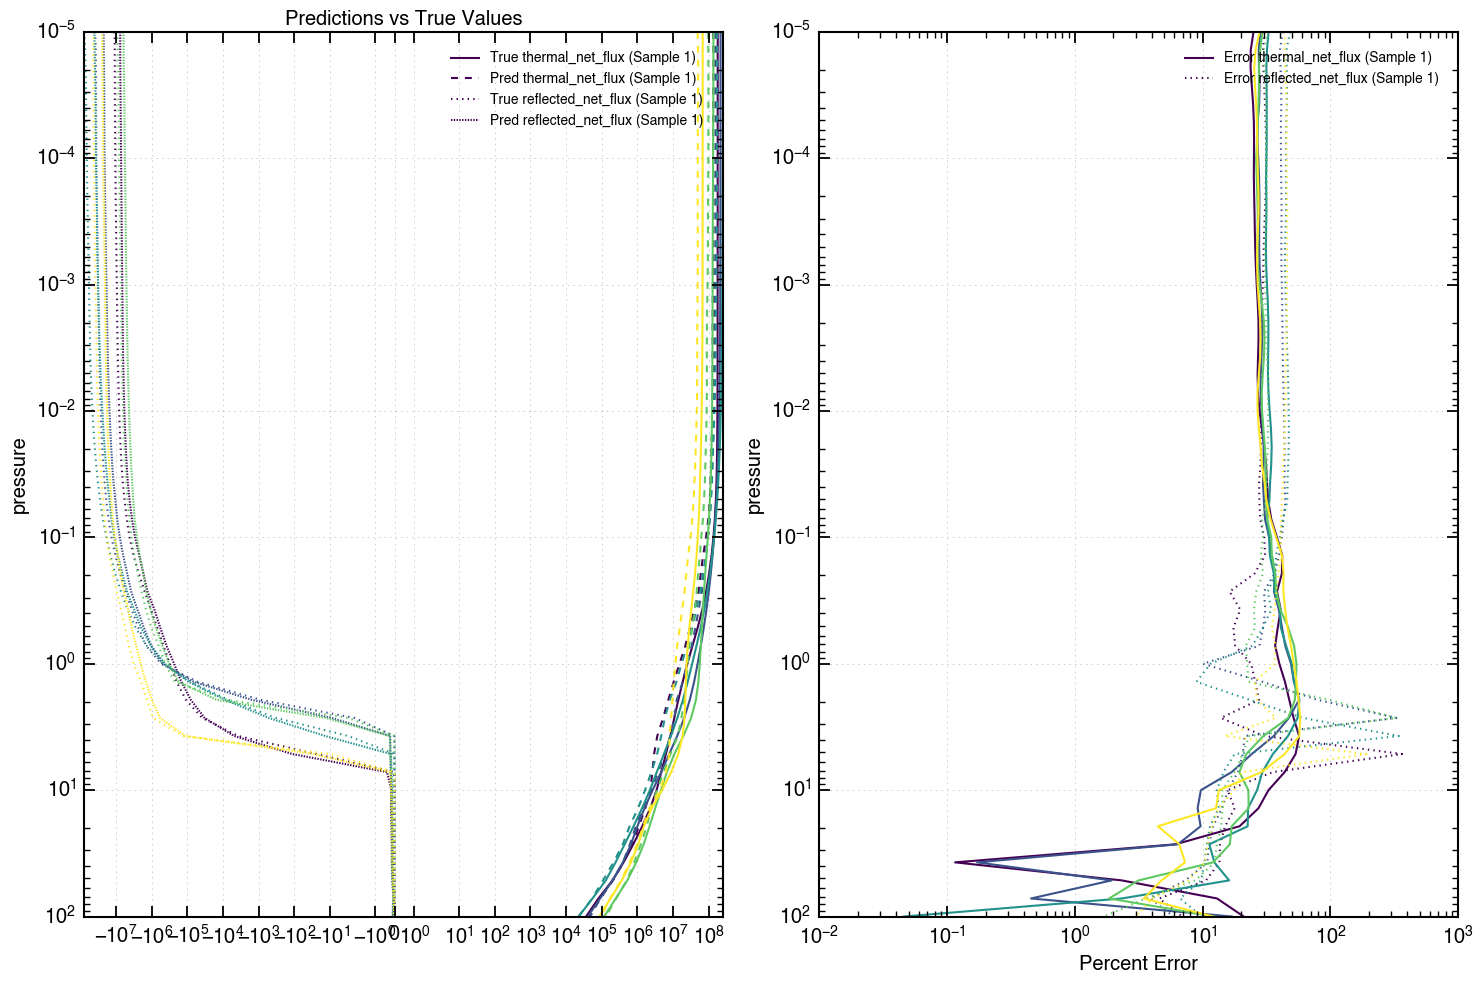

In [2]:
#!/usr/bin/env python3
"""
simple_plot.py - Minimal script to plot model predictions against true values
with percent error. Adapted for the simplified transformer model.
"""

import sys
sys.path.append('../src')

import json
import json5
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils import create_prediction_model
from normalizer import DataNormalizer
import time

plt.style.use('science.mplstyle')

# Hard-coded paths
DATA_PATH = "../data/normalized_profiles"
METADATA_PATH = "../data/normalized_profiles/normalization_metadata.json"
MODEL_PATH = "../data/model/best_model.pt"
CONFIG_PATH = "../inputs/model_input_params.jsonc"

# Load configuration
with open(CONFIG_PATH, 'r') as f:
    config = json5.load(f)

# Get variable names from config
input_vars = config["input_variables"]
target_vars = config["target_variables"]
feature1, feature2 = target_vars[0], target_vars[1]  # Features to plot
coord_var = "pressure"  # Coordinate variable

# Load the model and its weights
checkpoint = torch.load(MODEL_PATH, map_location='cpu')
model = create_prediction_model(config)

try:
    model.load_state_dict(checkpoint['state_dict'], strict=True)
    print("Loaded model weights with strict=True")
except RuntimeError as e:
    print(f"Warning: Could not strictly load model. Attempting flexible loading. Error: {e}")
    try:
        model.load_state_dict(checkpoint['state_dict'], strict=False)
        print("Loaded model weights with strict=False")
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Continuing with uninitialized model weights")

model.eval()

# Load normalization metadata
with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)

# Get test files (skip the metadata file)
test_files = [f for f in Path(DATA_PATH).glob("*.json") if f.name != "normalization_metadata.json"][:5]
colors = plt.cm.viridis(np.linspace(0, 1, len(test_files)))

# Create figure with two subplots: one for predictions vs truth, one for percent error
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10), sharex=False)

for i, (file_path, color) in enumerate(zip(test_files, colors)):
    try:
        # Load the profile data
        with open(file_path, 'r') as f:
            profile = json.load(f)
        
        # Get coordinate values (e.g., pressure levels)
        coord_vals = profile.get(coord_var, [])
        if not isinstance(coord_vals, list):
            coord_vals = [coord_vals]
        seq_len = len(coord_vals)
        
        # Prepare model inputs
        inputs = {}
        
        # Global features
        global_indices = config.get("global_feature_indices", [])
        if global_indices:
            global_values = []
            for idx in global_indices:
                val = profile.get(input_vars[idx], 0)
                val_float = float(val[0]) if isinstance(val, list) and val else float(val)
                global_values.append(val_float)
            inputs["global"] = torch.tensor(global_values, dtype=torch.float32).unsqueeze(0)
        
        # Sequence features - get the first sequence type only
        seq_types = config.get("sequence_types", {"profile": []})
        seq_type = list(seq_types.keys())[0]  # Use only the first sequence type
        indices = seq_types[seq_type]
        
        if indices:
            seq_features = []
            for idx in indices:
                val = profile.get(input_vars[idx], 0)
                if isinstance(val, list):
                    if len(val) < seq_len:
                        values = val + [val[-1]] * (seq_len - len(val))
                    else:
                        values = val[:seq_len]
                else:
                    values = [float(val)] * seq_len
                seq_features.append(torch.tensor(values, dtype=torch.float32))
            
            if seq_features:
                inputs[seq_type] = torch.stack(seq_features, dim=1).unsqueeze(0)
        
        # Run prediction
        with torch.no_grad():
            start_time = time.time()
            predictions = model(inputs)
            end_time = time.time()

            print(end_time - start_time)
            if predictions.dim() == 2:
                predictions = predictions.unsqueeze(1)
        
        print(f"Prediction shape for {file_path.name}: {predictions.shape}")
        
        # Plot for each target feature
        for j, feature in enumerate([feature1, feature2]):
            target_idx = target_vars.index(feature)
            true_vals = profile.get(feature, [0] * seq_len)
            if not isinstance(true_vals, list):
                true_vals = [true_vals] * seq_len
            
            # Extract predictions
            pred_vals = predictions[0, :seq_len, target_idx].cpu().numpy()
            pred_vals = pred_vals[:seq_len]
            
            # Denormalize values
            true_denorm = np.array(DataNormalizer.denormalize(true_vals, metadata, feature)).flatten()
            pred_denorm = np.array(DataNormalizer.denormalize(pred_vals, metadata, feature)).flatten()
            coord_denorm = np.array(DataNormalizer.denormalize(coord_vals, metadata, coord_var)).flatten()
            
            # Ensure arrays are the same length
            min_len = min(len(true_denorm), len(pred_denorm), len(coord_denorm))
            true_denorm = true_denorm[:min_len]
            pred_denorm = pred_denorm[:min_len]
            coord_denorm = coord_denorm[:min_len]
            
            # Calculate percent error
            epsilon = 1  # Avoid division by zero
            error = 100 * np.abs(pred_denorm - true_denorm) / np.maximum(np.abs(true_denorm), epsilon)
            
            # Plot predictions vs. truth
            linestyle = '-' if j == 0 else ':'
            label_suffix = feature1 if j == 0 else feature2
            ax1.plot(true_denorm, coord_denorm, color=color, linestyle=linestyle,
                     label=f"True {label_suffix} (Sample {i+1})" if i == 0 else None)
            ax1.plot(pred_denorm, coord_denorm, color=color, linestyle=linestyle,
                     dashes=(5,5) if j == 0 else (1,1),
                     label=f"Pred {label_suffix} (Sample {i+1})" if i == 0 else None)
            
            # Plot percent error
            ax2.plot(error, coord_denorm, color=color, linestyle=linestyle,
                     label=f"Error {label_suffix} (Sample {i+1})" if i == 0 else None)
            
    except Exception as e:
        print(f"Error processing file {file_path.name}: {e}")

# Configure the plots
ax1.set_ylabel(coord_var)
ax1.set_title("Predictions vs True Values")
ax1.set_yscale('log')
ax1.set_xscale('symlog')
ax1.set_ylim(1e2, 1e-5)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize='small')

ax2.set_xlabel("Percent Error")
ax2.set_ylabel(coord_var)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlim(1e-2, 1e3)
ax2.set_ylim(1e2, 1e-5)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize='small')

plt.tight_layout()
output_dir = Path("../plots")
output_dir.mkdir(exist_ok=True)
plt.savefig(output_dir / "model_comparison.png")
plt.show()